In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math

In [8]:
!ls airbus/

train_ship_segmentations_boxes.csv  train_ship_segmentations_v2.csv


In [9]:
BOXES_PATH = 'airbus/train_ship_segmentations_boxes.csv'
#IMG_PATH = '../input/airbus-ship-detection/train/'
box_df = pd.read_csv(BOXES_PATH)
box_df.head()

,EncodedPixels,ImageId,angle,lx,ly,x,y
0,NaN,00003e153.jpg,NaN,NaN,NaN,NaN,NaN
1,264661 17 265429 33 266197 33 266965 33 267733...,000155de5.jpg,-0.031697,102.440949,32.901931,395.235055,482.511398
2,101361 1 102128 3 102896 4 103663 6 104430 9 1...,00021ddc3.jpg,-0.587604,36.325820,11.545350,149.224538,746.349941
3,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...,00021ddc3.jpg,-0.603009,11.772402,7.361299,128.813435,760.125980
4,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...,00021ddc3.jpg,0.153686,11.092947,3.825867,100.992299,717.049660


In [12]:
#convert RLE mask into 2d pixel array
def encode_mask(mask, shape=(768,768)):
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    s = mask.split()
    for i in range(len(s)//2):
        start = int(s[2*i]) - 1
        length = int(s[2*i+1])
        img[start:start+length] = 1
    return img.reshape(shape).T

#get bounding box for a mask
def get_bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

#add padding to the bounding box
def get_bbox_p(img, padding=5):
    x1,x2,y1,y2 = get_bbox(img)
    lx,ly = img.shape
    x1 = max(x1-padding,0)
    x2 = min(x2+padding+1, lx-1)
    y1 = max(y1-padding,0)
    y2 = min(y2+padding+1, ly-1)
    return x1,x2,y1,y2

#convert parameters of the box for plotting
def convert_box(box):
    rot1 = math.cos(box[4])
    rot2 = math.sin(box[4])
    bx1 = box[0] - 0.5*(box[2]*rot1 - box[3]*rot2)
    bx2 = box[1] - 0.5*(box[2]*rot2 + box[3]*rot1)
    return (bx1,bx2,box[2],box[3],box[4]*180.0/math.pi)

def get_rec(box,width=1):
    b = convert_box(box)
    return patches.Rectangle((b[0],b[1]),b[2],b[3],b[4],linewidth=width,edgecolor='g',facecolor='none')

In [13]:
#plot image, mask, zoomed image, and zoomed mask with rotating bounding boxes
def show_box(idx):
    row = box_df.iloc[idx]
    name, encoding, x, y, lx, ly, rot = row.ImageId, row.EncodedPixels, \
        row.x, row.y, row.lx, row.ly, row.angle
    if(type(encoding) == float): return #empty image

    mask = encode_mask(encoding)
    box = (x,y,lx,ly,rot)
    image = np.asarray(Image.open(os.path.join(IMG_PATH,name)))
    
    fig,ax = plt.subplots(2, 2, figsize=(16, 16))
    ax[0,0].imshow(image)
    ax[0,1].imshow(mask)
    ax[0,0].add_patch(get_rec(box))
    ax[0,1].add_patch(get_rec(box))
    
    y1,y2,x1,x2 = get_bbox_p(mask,10)
    box_c = (x-x1,y-y1,lx,ly,rot)
    ax[1,0].imshow(image[y1:y2,x1:x2,:])
    ax[1,1].imshow(mask[y1:y2,x1:x2])
    ax[1,0].add_patch(get_rec(box_c,3))
    ax[1,1].add_patch(get_rec(box_c,3))
    
    for item in ax.flatten():
        item.axis('off')
    plt.show()

In [22]:
np.array([int(i) for i in box_df.loc[20, 'EncodedPixels'].split()]).shape

(434,)

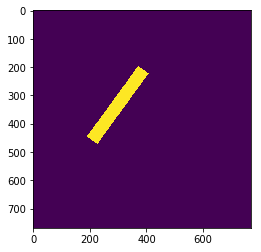

In [18]:
plt.imshow(encode_mask(box_df.loc[20, 'EncodedPixels']))